In [16]:
import rasterio
import numpy as np

# Load the image using rasterio
image_path = '/home/jovyan/shared/PCN/ALOS-2/Filter_ALOS2/2010HVfiltered5_image.tif'
#image_path = '/home/jovyan/shared/PCN/ALOS-2/Layerstack/07_10_HHstacked_output_new.tif'

with rasterio.open(image_path) as src:
    image = src.read()  # This will load all bands of the image
    profile = src.profile  # Metadata for saving later

# Check the shape of the image
print(image.shape)  # (bands, height, width)


(1, 9000, 9000)


In [17]:
import geopandas as gpd

# Load the training data (shapefile containing points or polygons with labels)
training_data = gpd.read_file('/home/jovyan/shared/PCN/ALOS-2/LULC/samples.shp')

# Training data must contain labeled points with classes (e.g., 1 for forest, 2 for urban, etc.)


In [18]:
from rasterio.features import geometry_mask

def extract_features_labels(image, training_data):
    features = []
    labels = []

    for idx, row in training_data.iterrows():
        geom = row['geometry']
        label = row['labels']  # The class label for each polygon/point
        
        # Mask to extract pixel values inside the training polygons
        mask = geometry_mask([geom], out_shape=(image.shape[1], image.shape[2]), transform=src.transform, invert=True)
        pixels = image[:, mask]
        
        # Add to features and labels
        features.append(pixels.T)
        labels.append([label] * pixels.shape[1])

    # Reshape features and labels
    features = np.vstack(features)
    labels = np.hstack(labels)
    
    return features, labels

# Extract features and labels
features, labels = extract_features_labels(image, training_data)


In [19]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForest model
rf = RandomForestClassifier(n_estimators=100, random_state=80)

# Train the model on the training data
rf.fit(features, labels)


RandomForestClassifier(random_state=80)

In [12]:
import numpy as np

# Check if there are NaN values in the labels
print(np.isnan(labels).any())


False


In [20]:
# Reshape the image for prediction (stack all bands as features)
n_bands, height, width = image.shape
reshaped_image = image.reshape(n_bands, height * width).T

# Predict the class for each pixel
classified_image = rf.predict(reshaped_image)

# Reshape the classified image back to the original dimensions
classified_image = classified_image.reshape(height, width)


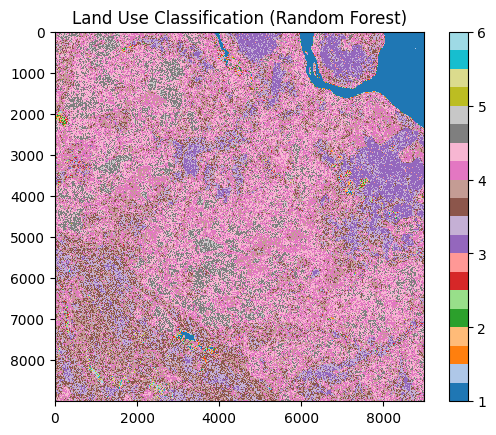

In [21]:
import matplotlib.pyplot as plt

# Plot the classified image
plt.imshow(classified_image, cmap='tab20')
plt.title('Land Use Classification (Random Forest)')
plt.colorbar()
plt.show()


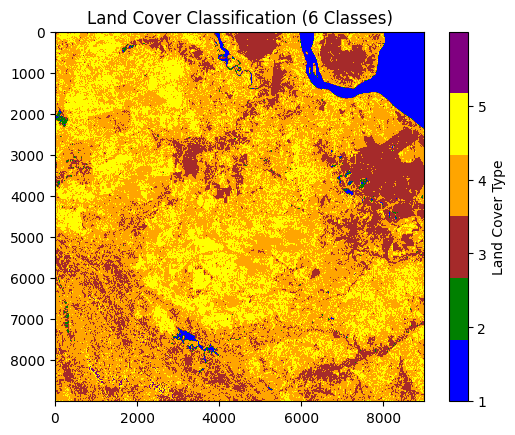

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define 6 colors for the classes (you can adjust these colors as needed)
colors = ['blue', 'green', 'brown', 'orange', 'yellow', 'purple']
cmap = ListedColormap(colors)

# Plot the classified image with the custom 6-color colormap
plt.imshow(classified_image, cmap=cmap)
plt.title('Land Cover Classification (6 Classes)')
plt.colorbar(ticks=[0, 1, 2, 3, 4, 5], label='Land Cover Type')  # Add ticks for each class
plt.show()


In [15]:
#Save the Classified Image
classified_profile = profile.copy()
classified_profile.update(dtype=rasterio.uint8, count=1)

with rasterio.open('/home/jovyan/shared/PCN/ALOS-2/LULC/2010_classified_image.tif', 'w', **classified_profile) as dst:
    dst.write(classified_image.astype(rasterio.uint8), 1)
